In [ ]:
# Script to make a phase diagram to illustrate loss vs input sparsity vs training sparsity for 
# different toy models

In [1]:
# Set up notebook

"""Import necessary packages"""

%load_ext autoreload
%autoreload 2

import os
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_weight_bars, plot_input_output_response
from toy_cis.util import threshold_matrix, in_out_response

"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A40'


In [2]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, x + t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    n_steps: int,
    lr: float,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []
    
    optimizer = t.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        
        # Update the learning rate
        current_lr = lr * np.cos(0.5 * np.pi * step / (n_steps - 1))
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

## 1. *ReLU_PlusX with Identity Embedding (= no embedding)*

Target: 
$$
y = x + ReLU(x)
$$

Linear map: 

$$
h = ReLU(W_1x)$$
$$
y' = W_2h + x
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1)
$$

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

In [4]:
"""Initialize model."""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_noEmbed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=False,
)

In [10]:
""" Train and test over a wide range of sparsities"""

sparsities = np.array([0.1, 0.3, 0.5, 0.75, 0.90, 0.95, 0.99])
feat_importance = 1
lr = 3e-3
n_steps = 10000
logging_freq = n_steps // 10
batch_sz = 1024

# iterate over sparsities for training and test at all sparsity levels
loss_data = []
for spar in sparsities: 
    
    """Train model at a certain sparsity"""
    
    reluPlusX_res_noEmbed_cis = Cis(reluPlusX_res_noEmbed_cfg, device=device).to(device)

    if spar >= 0.9:
        n_steps = 50000
    feat_sparsity = spar
    
    losses = train(
            reluPlusX_res_noEmbed_cis,
            batch_sz,
            feat_sparsity,
            feat_importance,
            loss_fn,
            n_steps,
            lr, 
            logging_freq
    )
    display(losses)

    """Get loss at inference over varying sparsity levels."""
    batch_sz = 256
    feat_importance = 1
    logging_freq = n_steps // 10


    pbar = tqdm(sparsities, desc="Testing over sparsities")
    n_examples = 10000
    
    for s in pbar:
    
        with t.no_grad():
            # generate examples of inputs
            x, y_true = gen_batch(reluPlusX_res_noEmbed_cis, n_examples, s)
            
            # compute mean loss
            y = reluPlusX_res_noEmbed_cis.forward(x)
            active_weight, inactive_weight = 10, 1
            weights = t.where(y_true == 1, active_weight, inactive_weight)
            loss = weights * (y - y_true) ** 2
            
            # store loss at sparsity level
            loss = rearrange(loss, "examples 1 features -> examples features")
            loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
            for feat_idx, val in enumerate(loss):
                loss_data.append({"train_sparsity":spar, "input_sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})
    
    """Get polysemanticity level as number of features per neuron""""
    W = einsum(relu_cis.W1, relu_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature")
    W = threshold_matrix(W.squeeze(), threshold=0.001)

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.14935074746608734,
 0.0626162514090538,
 0.05049818009138107,
 0.050069551914930344,
 0.049861736595630646,
 0.04990462213754654,
 0.05027263984084129,
 0.05036380514502525,
 0.05033858120441437,
 0.04999649524688721,
 0.04982961714267731]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.1167692318558693,
 0.055114954710006714,
 0.044220179319381714,
 0.04370035231113434,
 0.04345827177166939,
 0.04395730420947075,
 0.04314380884170532,
 0.044267065823078156,
 0.04269200190901756,
 0.04338289052248001,
 0.04339148476719856]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.08325239270925522,
 0.03813057765364647,
 0.03371553495526314,
 0.03478157892823219,
 0.03474462777376175,
 0.034128788858652115,
 0.033878400921821594,
 0.033293403685092926,
 0.03378641977906227,
 0.03382235765457153,
 0.03419019281864166]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.040713392198085785,
 0.02087368257343769,
 0.019324617460370064,
 0.018668001517653465,
 0.018899431452155113,
 0.01936851441860199,
 0.01854543201625347,
 0.01989203691482544,
 0.01996799185872078,
 0.01840376853942871,
 0.019065486267209053]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.016935404390096664,
 0.008913525380194187,
 0.008232503198087215,
 0.00792133528739214,
 0.00802629068493843,
 0.007474316284060478,
 0.007950779050588608,
 0.008342750370502472,
 0.008370833471417427,
 0.007953242398798466,
 0.008193726651370525]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.008365313522517681,
 0.004858293104916811,
 0.004158001393079758,
 0.004068579990416765,
 0.00436159735545516,
 0.0037860411684960127,
 0.003927893936634064,
 0.004200940486043692,
 0.004382460843771696,
 0.004440937656909227,
 0.003675742307677865]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.0016621197573840618,
 0.00100421579554677,
 0.0007462590583600104,
 0.0010086208349093795,
 0.0007955661276355386,
 0.0007508096168749034,
 0.0010209673782810569,
 0.0010324050672352314,
 0.0009935307316482067,
 0.0008643639739602804,
 0.0008224441553466022]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

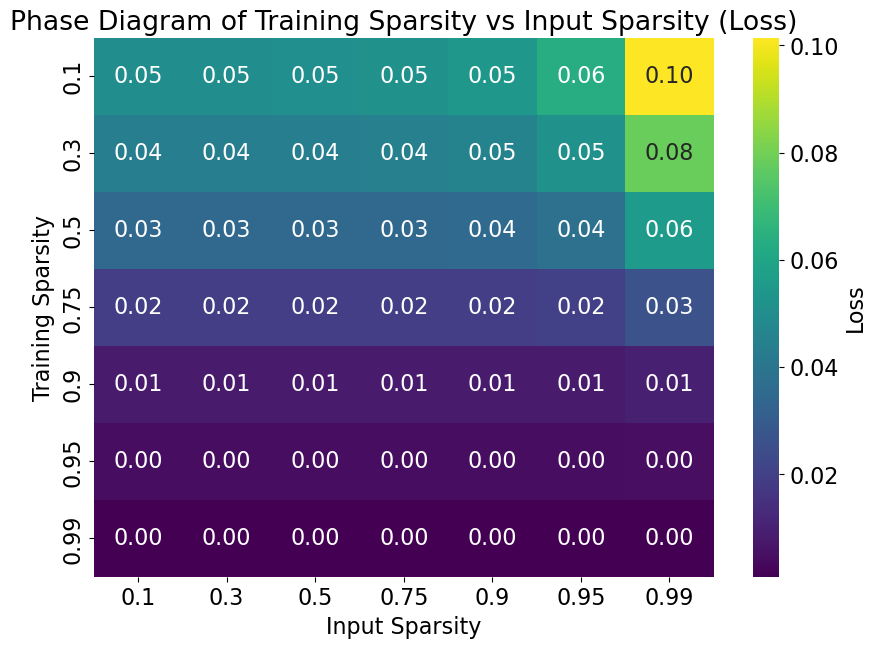

In [11]:
"""Plot phase diagram"""
loss = pd.DataFrame(loss_data)

# Aggregate loss_per_feature over feature_idx
loss_avg = loss.groupby(["train_sparsity", "input_sparsity"])["loss_per_feature"].mean().reset_index()
loss_avg["1-S"] = 1 - loss_avg["input_sparsity"]
loss_avg["loss/1-S"] = loss_avg["loss_per_feature"] / (1 - loss_avg["input_sparsity"])

# Create pivot table for heatmap
pivot_table = loss_avg.pivot(index="input_sparsity", columns="train_sparsity", values="loss/1-S")

# Plot phase diagram
plt.figure(figsize=(10, 7))
sns.heatmap(pivot_table, cmap="viridis", annot=True, fmt=".2f", cbar_kws={'label': 'Adjusted loss'})

plt.xlabel("Input Sparsity")
plt.ylabel("Training Sparsity")
plt.title("Phase Diagram of Training Sparsity vs Input Sparsity (Loss)")
plt.show()

## 2. *ReLU_PlusX with Random Embedding*

Target: 
$$
y = x + ReLU(x)
$$

Linear map: 

$$
e = W_e x$$
$$h = ReLU(W_1 e)$$
$$u = W_2 h + x$$
$$y' = W_u u
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1) \\
$$

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

In [12]:
"""Initialize model."""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000
)

In [13]:
""" Train and test over a wide range of sparsities"""

sparsities = np.array([0.1, 0.3, 0.5, 0.75, 0.90, 0.95, 0.99])
feat_importance = 1
lr = 3e-3
n_steps = 10000
logging_freq = n_steps // 10
batch_sz = 1024

# iterate over sparsities for training and test at all sparsity levels
loss_data = []
for spar in sparsities: 
    """Train model at a certain sparsity"""
    
    reluPlusX_res_embed_cis = Cis(reluPlusX_res_embed_cfg, device=device)
    
    feat_sparsity = spar
    
    losses = train(
        reluPlusX_res_embed_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        n_steps,
        lr, 
        logging_freq
    )
    display(losses)

    """Get loss at inference over varying sparsity levels."""


    batch_sz = 256
    feat_importance = 1
    logging_freq = n_steps // 10


    pbar = tqdm(sparsities, desc="Testing over sparsities")
    n_examples = 10000
    
    for s in pbar:
    
        with t.no_grad():
            # generate examples of inputs
            x, y_true = gen_batch(reluPlusX_res_embed_cis, n_examples, s)
            
            # compute mean loss
            y = reluPlusX_res_embed_cis.forward(x)
            active_weight, inactive_weight = 10, 1
            weights = t.where(y_true == 1, active_weight, inactive_weight)
            loss = weights * (y - y_true) ** 2
            
            # store loss at sparsity level
            loss = rearrange(loss, "examples 1 features -> examples features")
            loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
            for feat_idx, val in enumerate(loss):
                loss_data.append({"train_sparsity":spar, "input_sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.18024761974811554,
 0.05249461904168129,
 0.052647292613983154,
 0.05208409205079079,
 0.05216963589191437,
 0.05186299979686737,
 0.05147644504904747,
 0.051086682826280594,
 0.05185798928141594,
 0.05176851525902748,
 0.051331911236047745]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.13858920335769653,
 0.04651445150375366,
 0.04637885466217995,
 0.04646202549338341,
 0.047975827008485794,
 0.046626780182123184,
 0.045424479991197586,
 0.04654689505696297,
 0.04685316979885101,
 0.0459868423640728,
 0.0440940335392952]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.10102582722902298,
 0.03746355324983597,
 0.03818455711007118,
 0.03685963898897171,
 0.03610127419233322,
 0.03673049807548523,
 0.03573060408234596,
 0.036759886890649796,
 0.03577686846256256,
 0.03626769408583641,
 0.03650156408548355]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.049842413514852524,
 0.019914431497454643,
 0.02087531052529812,
 0.019893743097782135,
 0.019718220457434654,
 0.01963525265455246,
 0.019738707691431046,
 0.01944071054458618,
 0.019954029470682144,
 0.019049368798732758,
 0.019455520436167717]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.019360588863492012,
 0.00835496373474598,
 0.00780990207567811,
 0.007993440143764019,
 0.008078507147729397,
 0.008001221343874931,
 0.007731814403086901,
 0.007846563123166561,
 0.0077861580066382885,
 0.007659127004444599,
 0.0077096037566661835]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.01033779140561819,
 0.003938645590096712,
 0.0037763055879622698,
 0.0036922022700309753,
 0.003702448448166251,
 0.0038718469440937042,
 0.0037875231355428696,
 0.0033399155363440514,
 0.0038001660723239183,
 0.003685913048684597,
 0.0035793392453342676]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.0015662511577829719,
 0.0008267323719337583,
 0.0007602684199810028,
 0.0007430132245644927,
 0.0006434781826101243,
 0.0007946766563691199,
 0.000674744660500437,
 0.0007393394480459392,
 0.0007425573421642184,
 0.0006531499093398452,
 0.0006009407225064933]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

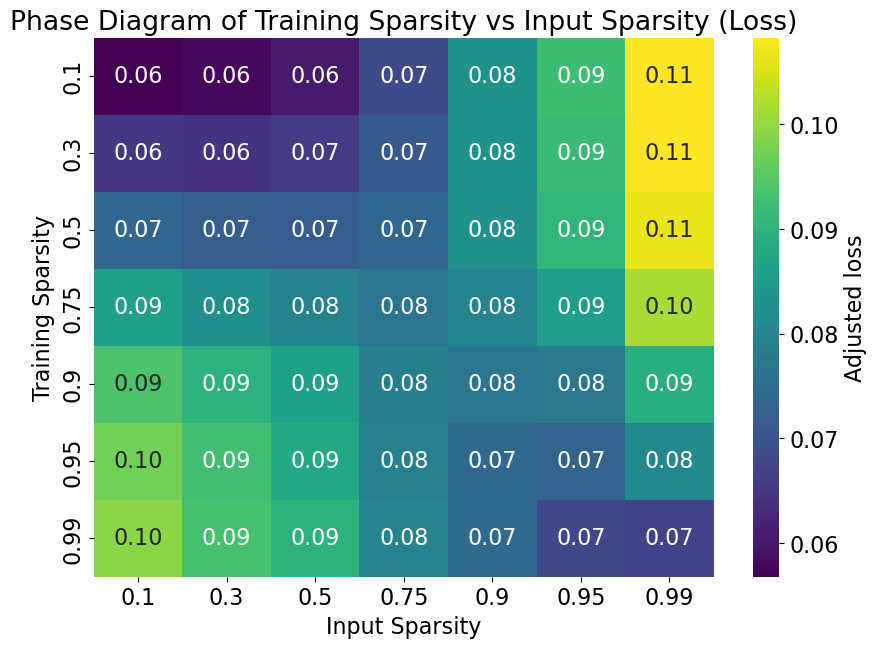

In [16]:
"""Plot phase diagram"""
loss = pd.DataFrame(loss_data)

# Aggregate loss_per_feature over feature_idx
loss_avg = loss.groupby(["train_sparsity", "input_sparsity"])["loss_per_feature"].mean().reset_index()
loss_avg["1-S"] = 1 - loss_avg["input_sparsity"]
loss_avg["loss/1-S"] = loss_avg["loss_per_feature"] / (1 - loss_avg["input_sparsity"])

# Create pivot table for heatmap
pivot_table = loss_avg.pivot(index="input_sparsity", columns="train_sparsity", values="loss/1-S")

# Plot phase diagram
plt.figure(figsize=(10, 7))
sns.heatmap(pivot_table, cmap="viridis", annot=True, fmt=".2f", cbar_kws={'label': 'Adjusted loss'})

plt.xlabel("Input Sparsity")
plt.ylabel("Training Sparsity")
plt.title("Phase Diagram of Training Sparsity vs Input Sparsity (Loss)")
plt.show()